# Treating Beaches Seperately

## Importing

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
from geopy import Nominatim

In [5]:
import urllib.request
import json

In [6]:
import folium

In [7]:
nomi_obj = Nominatim(user_agent='Coursera_Student')

In [8]:
pd.set_option('display.max_rows', 500)

## Defining functions

### Coords

In [9]:
def frame_coords(lst, col_name='venue'):
    coords = []
    fail_list = []
    
    cnt = 0
    for item in lst:
        
        cnt2 = 0
        try:
            location = None
            while (location==None) and (cnt2<5):
                location = nomi_obj.geocode(item)
                cnt2+=1
                        
            if location!=None: coords.append((item, location[1][0], location[1][1]))
            else: 
                fail_list.append(item)
                print('Fail:', item)
                
            cnt = cnt+1
            if cnt in range(1, 500, 8): print('Appended:', len(coords), 'Attempts:', cnt)
        except: print(nomi_obj.geocode(item), location)
            
    print('Fail List: ', fail_list) 
    print('Completed')
    return pd.DataFrame(coords, columns=[col_name, 'lat', 'lng'])

### Mapping Functions

In [10]:
def plot_map(df, zoom=10):
    mapa = folium.Map(location = [-22.911014, -43.209373], zoom_start = zoom)


    for lat, lng, label in zip(df['lat'], df['lng'], df.iloc[:, 0]):
    
        label = folium.Popup(label, html_parser=True)
        folium.CircleMarker([lat, lng],
                            popup=label,
                            radius=3,
                            color='darkorange',
                            #fill=True,
                            #fill_color='blue',
                            #fill_oppacity=0.8
                           ).add_to(mapa)
    return mapa

In [11]:
def plot_map_lite(df, zoom=11):
    
    mapa = folium.Map(location = [-22.911014, -43.209373], zoom_start=zoom)

    for lat, lng, label in zip(df['lat'].values, df['lng'].values, df.iloc[:, 0].values):
    
        #label = folium.Popup(label, html_parser=True)
        folium.CircleMarker([lat, lng],
                            #popup=label,
                            radius=2,
                            color='darkred',
                            #fill=True,
                            #fill_color='blue',
                            #fill_oppacity=0.8
                           ).add_to(mapa)
    return mapa

In [12]:
def plot_search_map(df, zoom=11):
    
     
    mapa = folium.Map(location = [-22.911014, -43.209373], zoom_start=zoom)

    for lat, lng, label, radius in zip(df['lat'].values, df['lng'].values, df.iloc[:, 0].values, df['radius'].values):
    
        #label = folium.Popup(label, html_parser=True)
        folium.Circle([lat, lng],
                      #popup=label,
                      radius=radius,
                      color='darkred',
                      #fill=True,
                      #fill_color='blue',
                      #fill_oppacity=0.8
                     ).add_to(mapa)
    return mapa
    

### Foursquare Functions

In [15]:
def foursquare_url(query=False,
                   explore=False,
                   venue=False,
                   ctgr_search=False,
                   ctgr_explore=False,
                   search_query=None,
                   ctgr_id=None,
                   venue_id=None,
                   radius=1500,
                   LIMIT=800,
                   lat=-22.9719642,       # Rio de Janeiro Center Coords
                   lng=-43.1843432):

    CLIENT_ID = 'YBZLHWZRC4DJGEF2GVTRMDCQZBCZXDBC0ZXPAMHZFR0RF3BC' # your Foursquare ID
    CLIENT_SECRET = 'NXISZGNL4VVTR24LS2GE3ZVQ14URDHPP0S0UNJTC41CKFW4I' # your Foursquare Secret
    VERSION = '20200604'
    latitude=lat
    longitude=lng
    
    expl_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    query_url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    venue_url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    ctgr_expl_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&category_Id={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT, ctgr_id)
    ctgr_srch_url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT, ctgr_id)
    
    if ctgr_explore: return ctgr_expl_url
    if ctgr_search: return ctgr_srch_url
    if query: return query_url
    if explore: return expl_url
    if venue: return venue_url

In [16]:
def get_venues(df,
               radius = 1000,
               explore=False,
               query=False,
               ctgr_search=False,
               ctgr_explore=False, 
               ctgr_id=None,
               search_query=None
              ):
    
    if type(radius)==int: radius = [radius for i in range(len(df))]

    keeper_cols = [df.columns[0], 'venue.id', 'venue.name', 'venue.category_id', 'venue.category', 'venue.location.lat', 'venue.location.lng', 'venue.location.distance']
    keeper_cols_ctgr = [df.columns[0], 'id', 'name', 'category_id', 'category', 'location.lat', 'location.lng', 'location.distance']
    rqst_fail = []
    append_fail = []
    cnt = 0
    
    if ctgr_search: hoods_expl = pd.DataFrame(columns=keeper_cols_ctgr)
    else: hoods_expl = pd.DataFrame(columns=keeper_cols)
    
    
    
    for name, lat, lng, radius in zip(df.iloc[:, 0], df['lat'], df['lng'], radius):
     
        try: rqst_txt = urllib.request.urlopen(foursquare_url(explore=explore,
                                                              query=query,
                                                              ctgr_search=ctgr_search,
                                                              ctgr_explore=ctgr_explore,
                                                              ctgr_id=ctgr_id,
                                                              search_query=search_query,
                                                              lat=lat, 
                                                              lng=lng,
                                                              radius=radius)).read().decode()[:]
        except: 
            try: rqst_txt = urllib.request.urlopen(foursquare_url(explore=True,
                                                                  lat=lat, 
                                                                  lng=lng,
                                                                  radius=radius)).read().decode()[:]
            except:
                print(name)
                rqst_fail.append(name)
                continue

        if not ctgr_search: rqst_df = json_normalize(json.loads(rqst_txt)['response']['groups'][0]['items'])  
        else: rqst_df = json_normalize(json.loads(rqst_txt)['response']['venues'])
        
        if len(rqst_df)==0: 
            append_fail.append(name)
            continue
        
        rqst_df[keeper_cols[0]] = [name for i in range(len(rqst_df))]
    
        if not ctgr_search:            
            if 'venue.categories' in rqst_df.columns:
                rqst_df['venue.category_id'] = [i[0]['id'] if i!=[] else np.nan for i in rqst_df['venue.categories']] 
                rqst_df['venue.category'] = [i[0]['name'] if i!=[] else np.nan for i in rqst_df['venue.categories']]   
            else: 
                rqst_df['venue.category_id'] = [np.nan for i in range(len(rqst_df))]
                rqst_df['venue.category'] = [np.nan for i in range(len(rqst_df))]
                
            hoods_expl = pd.concat([hoods_expl, rqst_df[keeper_cols]], axis=0)
            
        else:
            if 'categories' in rqst_df.columns:
                rqst_df['category_id'] = [i[0]['id'] if i!=[] else np.nan for i in rqst_df['categories']] 
                rqst_df['category'] = [i[0]['name'] if i!=[] else np.nan for i in rqst_df['categories']]   
            else: 
                rqst_df['category_id'] = [np.nan for i in range(len(rqst_df))]
                rqst_df['category'] = [np.nan for i in range(len(rqst_df))]
                
            hoods_expl = pd.concat([hoods_expl, rqst_df[keeper_cols_ctgr]], axis=0)
        
        
        cnt+=1
        if cnt in range(0, len(df), 10): print('appended:', cnt, 'rqst_fail:', len(rqst_fail), 'append_fail:', len(append_fail))
    
    print('Searched:', len(df), 'Failed:', len(append_fail)+len(rqst_fail))
    print('Fail list: ', append_fail)
    print('Completed')
    return hoods_expl.reset_index(drop=True)


##  Loading dataframes

In [18]:
armazem = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Initial Data\\praias_armazeninho_raw.csv').drop('Unnamed: 0', axis=1)

In [19]:
wiki = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Initial Data\\praias_wikipedia_raw.csv').drop('Unnamed: 0', axis=1)

In [20]:
foursquare  = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Initial Data\\praias_foursquare.csv').drop('Unnamed: 0', axis=1)

In [225]:
wiki_coords1 = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Initial Data\\praias\\wiki_coords_bairro+praia.csv').drop('Unnamed: 0', axis=1)

In [ ]:
armazem

In [ ]:
wiki

In [ ]:
foursquare

# Requesting Armazeninho Coords

In [ ]:
armazem_coords = frame_coords(armazem['beach']+', RJ')

In [31]:
armazem_fail = ['Gaegos, RJ', 'Pelônias, RJ', 'Intendente Bittencourt, RJ', 'Saco do Pinhão, RJ', 'Pintor Castanheto, RJ', 'Dona Luiza ou Recôncavo, RJ', 'Barra de Guaratiba/Canto, RJ', 'Gávea ou Pepino, RJ', 'Grumari/Abricó, RJ', 'Pequena/Do Meio, RJ', 'Funda/Inferno, RJ']

In [ ]:
armaz

plot_map(armazen_coords)

# Filtering Armazeninho Coords

In [ ]:
armazen_coords.plot(kind='scatter', x='lng', y='lat')

In [ ]:
armazen_coords[armazen_coords['lat'] < -22.75][armazen_coords['lat'] > -23.1][armazen_coords['lng'] < -43.15].plot(kind='scatter', x='lng', y='lat')
plt.grid()

In [ ]:
armazem_filtered = armazen_coords[armazen_coords['lat'] < -22.75]
armazem_filtered = armazem_filtered[armazem_filtered['lat'] > -23.1]
armazem_filtered = armazem_filtered[armazem_filtered['lng'] < -43.15]
armazem_filtered = armazem_filtered[armazem_filtered['lng'] > -43.75]

In [ ]:
plot_map(armazem_filtered)

In [ ]:
len(armazem_filtered)

### Saving/Loading armazeninho filtered 1

In [67]:
armazem_filtered.to_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Initial Data\\praias\\armazem_praias_filtered1.csv')

In [68]:
armazem_filtered1 = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Initial Data\\praias\\armazem_praias_filtered1.csv')

# Foursquare Beaches: Manually Filtering

In [ ]:
foursquare

In [ ]:
plot_map(foursquare)

In [ ]:
foursquare_filt1 = foursquare[foursquare['name'].str.contains('praia', case=False)]

In [ ]:
plot_map(foursquare_filt1 )

In [ ]:
foursquare_out = ['Praia De Ipanema', 'Praia Privativa', 'Praia Dona Luíza', 'Pôr do Sol na Praia da Reserva', 'Praia da Gigóia', 'Trilha das Praias da Ponta de Guaratiba', 'Praia do Inferno', 'Praia 2', 'Praia 3', 'Praia dos Nogueira', 'Praia do Secreto', 'praia pontal', 'Ponta da Praia', 'Posto 12 / Praia', 'Praia do Recreio dos Bandeirantes', 'Balsa da Praia - Cidade Jardim', 'Praia do Alfa Barra', 'Um super cantinho de praia', 'Escritorio Da Praia', 'Praia', 'Praia Linda', 'Praia - Barraca Do Zacarias', 'Praia Jardim Oceânico', 'Praia da Barra Posto 2/3', 'Praia De Copa Em Frente A Xavier', 'Praia Laranjeira', 'Praia Grande - Fortaleza de São João', 'Praias', 'Praia Do Flamengo Calango Beach Tennis', 'Praia Do Chiclete', 'Praia de Ponta Negra', 'Praia do Zumbi', 'Praia Congonhas do Campo', 'Praia da Freguesia', 'Praia da Guarda']

In [ ]:
in_names = [i in foursquare_filt1['name'].values for i in foursquare_out]

In [ ]:
sum(in_names), len(foursquare_out)

In [163]:
foursquare_filt2 = foursquare_filt1[~foursquare_filt1['name'].isin(foursquare_out)]

### Saving Loading Foursquare Beaches Final

In [170]:
#foursquare_filt2.to_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Initial Data\\praias\\praias_foursquare_final.csv')

In [13]:
fr_sqr = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Initial Data\\praias\\praias_foursquare_final.csv').drop('Unnamed: 0', axis=1)

In [14]:
plot_map(fr_sqr)

## Foursquare Result Comparing


In [ ]:
fr_sqr.head()

In [ ]:
armazem.head()

In [190]:
contains_arm = []
for beach in armazem.beach:
    
    contains_arm.append(bool(sum(fr_sqr.name.str.contains(beach, case=False))))

In [ ]:
len(armazem[contains_arm]), len(fr_sqr)

In [192]:
contains_wiki = []
for beach in wiki.beach:
    
    contains_wiki.append(bool(sum(fr_sqr.name.str.contains(beach, case=False))))

In [ ]:
len(wiki[contains_wiki]), len(fr_sqr)

In [ ]:
armazem[[(not i) for i in contains_arm]].head()

In [ ]:
len(wiki[[not i for i in contains_wiki]])

# Wikipedia Beach Search Filtering

In [227]:
len(wiki_coords1)

65

### Filtering result 1

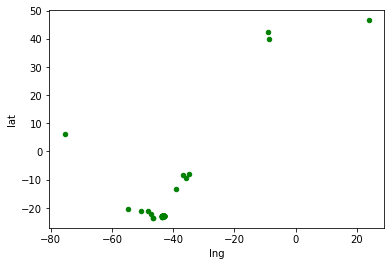

In [240]:
wiki_coords1.plot(kind='scatter', x='lng', y='lat', color='green')

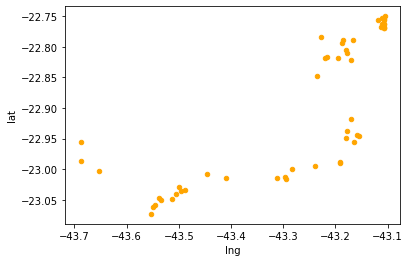

In [257]:
wiki_coords1[(wiki_coords1['lat']<-22.4) & (wiki_coords1['lat']>-23.4)].plot(kind='scatter', x='lng', y='lat', color='orange')

#### Extracting Good Results

In [248]:
wiki_coords1_filt = wiki_coords1[(wiki_coords1['lat']<-22.4) & (wiki_coords1['lat']>-23.4)]

In [ ]:
wiki_coords1_filt

#### Extracting bad Results


In [266]:
fail1 = wiki_coords1[(wiki_coords1['lat']>-22.4) & (wiki_coords1['lat']<-23.4)]

In [272]:
fail1 = wiki_coords1[~wiki_coords1['beach'].isin(wiki_coords1_filt['beach'])]['beach'].tolist()

In [273]:
len(fail1)

14

### Treating failed searches: 1

In [228]:
fail = ['Paquetá, Coqueiro', 'Paquetá, Coqueiros / Pintor Castagneto', 'Paquetá, Frades / Manoel Luiz', 'Paquetá, Gaivotas / Ribeira', 'Paquetá, Lameirão / Freire Júnior', 'Paquetá, Moreninha / Comprida / Dr. Aristão', 'Paquetá, Veloso', 'Bancários, Congonhas do Campo / Barão', 'Cacuia, Alentejo', 'Cacuia, Brava', 'Cacuia, Golfinho', 'Cidade Universitária, Amendoeira', 'Cidade Universitária, Duas Irmãs', 'Cidade Universitária, Polvo', 'Cidade Universitária, Varanda', 'Cidade Universitária, Velho Navio', 'Freguesia, Flamboyants', 'Freguesia, Guanabara / Freguesia', 'Freguesia, Pelônias', 'Freguesia, Saco do Pinhão', 'Galeão, Gaegos', 'Jardim Guanabara, Engenho Velho / Quebra-Coco', 'Ramos/Maré, Ramos', 'Barra da Tijuca, Barra da Tijuca', 'Barra de Guaratiba, Barra de Guaratiba', 'Barra de Guaratiba, Canto', 'Guaratiba, Brisa / Aterro', 'Grumari, Perigoso', 'Pedra de Guaratiba, Capela', 'Pedra de Guaratiba, Venda Grande', 'Sepetiba, Recôncavo / Dona Luiza', 'Copacabana, Prainha do Forte de Copacabana', 'Leme, Anel']

In [274]:
fail1

['Paquetá, Cidade',
 'Cidade Universitária, Coqueiros',
 'Cidade Universitária, Grande',
 'Freguesia, Grande',
 'Freguesia, Moça',
 'Galeão, Galeão',
 'Pitangueiras, Pitangueiras',
 'Ribeira, Ribeira',
 'Zumbi, Zumbi',
 'Copacabana, Copacabana',
 'Ipanema, Ipanema',
 'Leblon, Leblon',
 'Leme, Leme',
 'Urca, Urca']

In [284]:
com_barra = [i for i in fail if '/' in i]
sem_barra = [i for i in fail if '/' not in i]

#### Com Barra

In [278]:
com_barra1 = frame_coords([i.split(' / ')[0] for i in com_barra])

Appended: 1 Attempts: 1
Fail: Bancários, Congonhas do Campo
Fail: Jardim Guanabara, Engenho Velho
Fail: Ramos/Maré, Ramos
Appended: 6 Attempts: 9
Fail List:  ['Bancários, Congonhas do Campo', 'Jardim Guanabara, Engenho Velho', 'Ramos/Maré, Ramos']
Completed


In [279]:
com_barra1.drop(5, axis=0, inplace=True)

plot_map(com_barra1)

In [281]:
full_wiki = pd.concat([wiki_coords1_filt, com_barra1], axis=0)

In [282]:
#full_wiki.to_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Initial Data\\praias\\full_wiki1.csv')

In [286]:
com_barra

['Paquetá, Coqueiros / Pintor Castagneto',
 'Paquetá, Frades / Manoel Luiz',
 'Paquetá, Gaivotas / Ribeira',
 'Paquetá, Lameirão / Freire Júnior',
 'Paquetá, Moreninha / Comprida / Dr. Aristão',
 'Bancários, Congonhas do Campo / Barão',
 'Freguesia, Guanabara / Freguesia',
 'Jardim Guanabara, Engenho Velho / Quebra-Coco',
 'Ramos/Maré, Ramos',
 'Guaratiba, Brisa / Aterro',
 'Sepetiba, Recôncavo / Dona Luiza']

In [288]:
com_barra_fail = ['Bancários, Congonhas do Campo / Barão', 'Jardim Guanabara, Engenho Velho / Quebra-Coco', 'Ramos / Maré, Ramos', 'Freguesia, Guanabara / Freguesia']

In [289]:
com_barra2 = frame_coords([i.split(' / ')[1] for i in com_barra_fail])

Appended: 1 Attempts: 1
Fail List:  []
Completed


In [ ]:
plot_map(com_barra2)

In [294]:
com_barra2.loc[2]

venue    Maré, Ramos
lat         -22.8398
lng         -43.2515
Name: 2, dtype: object

In [295]:
com_barra_fail2 = ['Bancários, Congonhas do Campo / Barão', 'Jardim Guanabara, Engenho Velho / Quebra-Coco', 'Freguesia, Guanabara / Freguesia']

In [302]:
[i.split(', ')[0]+', '+i.split('/ ')[-1] for i in com_barra_fail2]

['Bancários, Barão', 'Jardim Guanabara, Quebra-Coco', 'Freguesia, Freguesia']

In [303]:
com_barra3 = frame_coords([i.split(', ')[0]+', '+i.split('/ ')[-1] for i in com_barra_fail2])

Appended: 1 Attempts: 1
Fail List:  []
Completed


In [309]:
com_barra3.loc[1]

venue    Jardim Guanabara, Quebra-Coco
lat                           -22.8155
lng                           -43.2112
Name: 1, dtype: object

#### Sem barra

In [ ]:
sem_barra1 = sem_barra = fail1 + com_barra_fail